# Differential privacy section project

This work is part of [Udacity](http://udacity.com) 'Secure and Private AI scholarship challenge nanodegree Program'. 

I study there how to protect customer personal data and still be able to train good ML models.
Here is my final project in section "Differential privacy."
In this project, I'm going to train a Differentially private model using PATE method on the MNIST dataset

### What is PATE method?
Private Aggregation of Teacher Ensembles or PATE.
In this approach, the model is not trained on sensitive data directly. 
Instead, multiple models trained on different subsets of users. These models called **teachers**.
Then, the **student** model trained on the noisy output of **teachers** models.

As result **student** model doesn't have direct access to data available to **teachers**, but still can make accurate predictions if **teachers** models generalize data very well.

### Points of complexity
- It is not always possible to identify people in datasets. 
       One person could write multiple handwritten digits in one set.
- Naural models rarely have the same state, even if it was trained on the same dataset.

### Task description

Let's imagine that we try to predict some labels, but our dataset unlabeled. However, we know that multiple different organizations have labeled data, but they are not going to share raw datasets with us. So we ask these organizations to train models on their side and provide us predictions for our dataset. Then we could label dataset available to us and train our model. Finally, we have to make sure that predictions that were provided for us are protected and there is no privacy leakage.

For this task, MNIST dataset should be separated into **teacher**(private) and **student**(public) parts. Each **teacher** dataset will contains both data(images) and targets(labels). **Student** dataset only contains 'data'. After that, ~40 **teachers** models trained on their datasets. Then, each trained model predict targets using public data. Each sample should have ~40 estimations, and the most popular answer selected as a label. The label should not depend on a prediction from a particular teacher, so each label should have some amount of noise. Finally, **student** model trained on a labeled dataset. True labels are removed from **student** datasets artificially in our case. As a result, we could make a decent estimation of prediction quality.

The goal is to answer the following questions:

- Id it keep *teachers* data private?

- Is it possible to train **student** without a massive loss in prediction quality?

- What is a necessary amount of noise to add to keep data private?

### Part 1: Prepare datasets for **teachers** and **student** 

**PyTorch** is the main framework to build and train models in this project. 
That means that input dataset should be tensors.
So, let's download MNIST dataset and make the necessary transformations.

In [1]:
import numpy as np
import torch

In [2]:
import torchvision.datasets as datasets
from torchvision import transforms
import torch.utils.data as data_utils

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,)),
                              ])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_trainloader = data_utils.DataLoader(mnist_trainset, batch_size=64, shuffle=True)

mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_testloader = data_utils.DataLoader(mnist_testset, batch_size=64, shuffle=True)

In [3]:
print(f"MNIST train size {len(mnist_trainset)}")
print(f"MNIST test size {len(mnist_testset)}")

MNIST train size 60000
MNIST test size 10000


We could use **PyTorch** build-in function `random_split` to split original dataset. `teachers_and_student_datasets` is a convenience function to divide dataset to equally between student and teachers. It helps us to avoid some complexity at the beginning.

In [4]:
def teachers_and_student_datasets(original_dataset, subset_size, parts, verbose=True):
    '''divide original dataset to equal subsets'''
    total = len(original_dataset)
    lengths = [subset_size] * parts + [total - subset_size * parts]
    if verbose:
        print(f"Subsets lengths {lengths}")
    datasets = data_utils.dataset.random_split(original_dataset, lengths)
    return (datasets[:parts - 1], datasets[parts-1])
    
def to_dataloader(dataset):
    return data_utils.DataLoader(dataset, batch_size=64, shuffle=False)

To train model each **teacher** and **student** should have train and test dataloaders. Also, **teacher** name is useful to track training progress. So, it is not a bad idea to group this data to one named tuple and store together.

In [5]:
from collections import namedtuple

DataInfo = namedtuple('DataInfo', 'name train test')

As it was mentioned earlier, **student** dataset only includes images, not labels.

In [6]:
def init_teachers_data(teachers_names, teachers_trainsets, teachers_testsets):
    teachers_train_dl = [to_dataloader(d) for d in teachers_trainsets]
    teachers_test_dl = [to_dataloader(d) for d in teachers_testsets] 

    teachers_data =[DataInfo(a[0], a[1], a[2]) for a in zip(teachers_names, teachers_train_dl, teachers_test_dl)]
    return teachers_data

def init_students_data(student_name, student_trainset, student_testset):
    # train set doesn't have lables
    student_train_dl = to_dataloader([img for img, lbl in student_trainset])
    student_test_dl = to_dataloader(student_testset)

    student_data = DataInfo(student_name, student_train_dl, student_test_dl)
    return student_data

Let's test our infrastructure on toy dataset first. In toy datasets, there are only 6 **teachers** with a set of 100 images each.

In [7]:
teachers_names = ['El', 'Max', 'Dustin', 'Will', 'Lukas', 'Mike']
student_name = "Demogorgon"
subset_size = 100

In [8]:
N = len(teachers_names)
teachers_trainsets, student_trainset = teachers_and_student_datasets(mnist_trainset, subset_size, N + 1)
teachers_testsets, student_testset = teachers_and_student_datasets(mnist_testset, subset_size, N + 1)

teachers_data = init_teachers_data(teachers_names, teachers_trainsets, teachers_testsets)
student_data = init_students_data(student_name, student_trainset, student_testset)

Subsets lengths [100, 100, 100, 100, 100, 100, 100, 59300]
Subsets lengths [100, 100, 100, 100, 100, 100, 100, 9300]


In [9]:
print(f"{student_data}")
print(f"{next(iter(student_data.train))}")

DataInfo(name='Demogorgon', train=<torch.utils.data.dataloader.DataLoader object at 0x1245efb38>, test=<torch.utils.data.dataloader.DataLoader object at 0x12452d208>)
tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
       

In [10]:
print(f"{len(teachers_data)}")
print(f"{teachers_data[2]}")
print(f"{next(iter(teachers_data[2].train))}")

6
DataInfo(name='Dustin', train=<torch.utils.data.dataloader.DataLoader object at 0x1249638d0>, test=<torch.utils.data.dataloader.DataLoader object at 0x124963cc0>)
[tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]],


        [[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
        

### Part 2: Select a model
Building a perfect predictor is not the primary goal in this project, and the dataset is very simple. So, an unsophisticated, fully connected neural network should be a good fit


SimpleModel object is very general, so neither PATE approach or MNIST dataset is mentioned in an object definition. This generalization is an advantage so that it could be easily replaced and changed or served for a different purpose. 
In this project, **student** and **teachers**  use the same type of model, but this is not required. In real-world, a trained model should be eighter shared as a file or, even better, has a dedicated prediction service with proper logs and authorization. However, I'll skip this part for now.

In [11]:
from torch import nn, optim
import torch.utils.data as ds
import functools

class SimpleModel():
    '''
    This is a simple 3-layers fully connected neural network for supervised learning
    
    Parameters
    ----------
    name : str
        The name is used to identify model and to track training progress
    trainloader : torch.utils.data.dataloader.DataLoader 
        Dataloader with train dataset
    testloader : torch.utils.data.dataloader.DataLoader
        Dataloader with test dataset

    Attributes
    ----------
    name : str 
        This is where we store model name
    model :
        This is where we store model
    train_epochs : int
        Amount of epochs used to train model (the default is 5)
    accuracy : float
        Store model's accuracy from the last validation round
    is_trained : bool
        Flag that shows if model training already finished
    '''
    
    INPUT_SIZE = 784
    OUTPUT_SIZE = 10
    
    def __init__(self, name, trainloader, testloader):
        super().__init__()
        self.trainloader = trainloader
        self.testloader = testloader
        self.name = name
        self.train_epochs = 5
        self._accuracy = 0
        self._model = None
        self._trained = False
        
    @property
    def model(self):
        if self._model is None:
            self._model = nn.Sequential(nn.Linear(self.INPUT_SIZE, 256),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        nn.Linear(256, 64),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        nn.Linear(64, self.OUTPUT_SIZE),
                                        nn.LogSoftmax(dim=1))
        return self._model
                                        
    @property
    def is_trained(self):
        return self._trained
    
    @property
    def accuracy(self):
        return self._accuracy
    
    def predict_labels(self, images):
        with torch.no_grad():
            self.model.eval()
            images = self.__flatten_input__(images)
            pred = torch.exp(self.model(images))
            # get one with highest probablity
            top_prob, top_class = pred.topk(1, dim=1)
            self.model.train()
        return top_class

    def test_model(self, dataloader):
        accuracy = 0
        for images, labels in dataloader:
            pred_labels = self.predict_labels(images)
            accuracy += self.__prediction_accuracy__(labels, pred_labels)
        return accuracy/len(dataloader)

    def train_model(self, verbose=True):
        criterion = nn.NLLLoss()
        optimizer = optim.Adam(self.model.parameters(), lr=0.005)
        self.__opt_print__(f"{self.name} starts training", verbose)
        for e in range(self.train_epochs):
            for images, labels in self.trainloader:
                images = self.__flatten_input__(images)
                optimizer.zero_grad()
                logits = self.model(images)
                loss = criterion(logits, labels)
                loss.backward()
                optimizer.step()
            else:
                self._accuracy = self.test_model(self.testloader)
                self.__opt_print__(f"Improved accuracy: {self._accuracy}", verbose)
        self._trained = True
        self.__opt_print__(f"{self.name} finished training", verbose)
        return self._model
    
    def __flatten_input__(self, images):
        images = images.view(images.shape[0], -1)
        assert(images.shape[1] == self.INPUT_SIZE)
        return images
    
    def __prediction_accuracy__(self, true_labels, pred_labels):
        '''helps to compare two tensors and return how similar they are in range 0...1'''
        equals = pred_labels == true_labels.view(*pred_labels.shape)
        return torch.mean(equals.type(torch.FloatTensor))
    
    def __opt_print__(self, message, verbose=True):
        if verbose:
            print(message)
    

In real live **teachers** would be trained on separate machines in parallel. However, because we just fake private datasets **teachers** are trained sequentially and stored in memory

In [12]:
teachers = []
for (name, trainloader, testloader) in teachers_data:
    t = SimpleModel(name, trainloader, testloader)
    t.train_model()
    teachers.append(t)

El starts training
Improved accuracy: 0.2126736044883728
Improved accuracy: 0.4713541567325592
Improved accuracy: 0.5789930820465088
Improved accuracy: 0.6675347089767456
Improved accuracy: 0.6814236044883728
El finished training
Max starts training
Improved accuracy: 0.4626736044883728
Improved accuracy: 0.5590277910232544
Improved accuracy: 0.5824652910232544
Improved accuracy: 0.6710069179534912
Improved accuracy: 0.7178819179534912
Max finished training
Dustin starts training
Improved accuracy: 0.3368055522441864
Improved accuracy: 0.4435763955116272
Improved accuracy: 0.5538194179534912
Improved accuracy: 0.5694444179534912
Improved accuracy: 0.5928819179534912
Dustin finished training
Will starts training
Improved accuracy: 0.1909722238779068
Improved accuracy: 0.4626736044883728
Improved accuracy: 0.5685763955116272
Improved accuracy: 0.6085069179534912
Improved accuracy: 0.6163194179534912
Will finished training
Lukas starts training
Improved accuracy: 0.2855902910232544
Improv

So far, everything looks fine. Datasets are small and are not very good predictors as expected

### Part 3: Public dataset labeling

First, we want to get a prediction from each teacher for every sample. This is function `predict_labels_per_teacher` is for.

In [13]:
def predict_labels_per_teacher(images, teachers):
    batch_size = images.shape[0]
    preds = np.empty([0, batch_size], dtype=int)
    for t in teachers:
        p = t.predict_labels(images).view(1, batch_size).numpy()
        preds = np.append(preds, p, axis=0)
    return preds

Second, for each sample, we should identify the most popular prediction using `bincount` and `argmax` functions and add noise to a prediction.

In function `select_best_labels` we use differential privacy to protect customers data.
If every teacher generalizes their models very well, then all teachers should agree on every label. In this case, we don't need to add noise to protect personal data: any teacher could be removed, but predicted labels stay the same. 
On the other hand, if different teacher predicts different labels for the same sample than more noise required to protect personal data. 

**Why should we add noise?** Imagine that **teachers** are hospitals and our model try to predict some sensitive information, for example, some disease. Also, let's imagine that all hospitals don't agree much in their predictions. In this case, if at least one hospital is removed from the process, predicted labels would change. In this case, we could deduct removed hospital bias and make an estimation of what diseases its customers most probably had. If the disease is rare than given information could be even linked to a real person. (although it requires access to some other private datasets or information).

**How much noise to add?** 
In this project, we generated noise using Laplace distribution with a peak around 0 and beta defined as: 

`beta = sensitivity / epsilon`. 

Sensitivity shows how much information we are leaking with one model prediction request. Epsilon identifies the maximum acceptable privacy leakage. 

Sensitivity value: 
In the worst-case, each teacher associated with exactly one person. So, at maximum, one person can change a label prediction by 1. In this case, the sensitivity of model prediction per each sample per teacher = 1. 
Epsilon value:
In general, we want to minimize epsilon. However, if it is too small, the beta should be huge, that means an enormous amount of noise in predictions. Noisy predictions lead to the poor performance of **student** model. So, we start with a value 0.25 and then try to minimize it, without a significant loss in prediction quality.

In [14]:
def select_best_labels(preds, use_noise=True, eps=0.25, num_labels=10):
    num_samples = preds.shape[1]
    labels = np.empty([0], dtype=int)
    for i in range(num_samples):
        counts = np.bincount(preds[:, i], minlength=num_labels)
        if use_noise:
            sensitivity = 1
            beta = sensitivity / eps
            noise = np.random.laplace(0, beta, len(counts)).astype(int)
            counts += noise
        labels = np.append(labels, np.argmax(counts))
    return labels

Function ```perform_analysis```  helps to identify optimal epsilon value.
Framework **PySyft** contains handy function `pate.perform_analysis` for this kind of tasks. It helps to identify how much teachers agree with each other to identify optimal epsilon. 

In [15]:
from syft.frameworks.torch.differential_privacy import pate

def perform_analysis(imageset, teachers, use_noise=True, eps=0.25, num_labels=10):
    all_preds = np.empty([len(teachers), 0], dtype=int)
    all_labels = np.empty([0], dtype=int)
    for images in imageset:
        preds = predict_labels_per_teacher(images, teachers)
        labels = select_best_labels(preds, use_noise=use_noise, eps=eps, num_labels=num_labels)
        all_preds = np.append(all_preds, preds, axis=1)
        all_labels = np.append(all_labels, labels)
    return pate.perform_analysis(teacher_preds=all_preds, indices=all_labels, noise_eps=eps, delta=1e-5) 

W0727 12:41:22.616033 4612605376 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was '/miniconda3/envs/pysyft/lib/python3.7/site-packages/tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0727 12:41:22.636858 4612605376 deprecation_wrapper.py:119] From /miniconda3/envs/pysyft/lib/python3.7/site-packages/tf_encrypted/session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



Let's check how new function works on a toy dataset

In [16]:
data_dep_eps, data_ind_eps = perform_analysis(student_data.train, teachers, use_noise=True, eps=0.25, num_labels=10)
print("Data Independent Epsilon:", data_ind_eps)
print("Data Dependent Epsilon:", data_dep_eps) 

Data Independent Epsilon: 36.51292546497023
Data Dependent Epsilon: 36.51292546497023


Data Independent and Dependent Epsilon are very close. There could be at least two reasons why this happened. Either our teachers predict labels almost randomly, or there is too much noise added. In this case, it is both. Indeed Laplace distribution with `beta = 1 / 0.25` generates noise that alters predictions completely.



Finally, let's create a function ```label_dataset ``` that uses all described functions to create a labeled dataset for **student**

In [17]:
def label_dataset(imageset, teachers, use_noise=True, eps=0.25, num_labels=10):
    ''' Create labeled dataset from images and teachers that helps to predict it '''
    datasets = []
    for images in imageset:
        preds = predict_labels_per_teacher(images, teachers)
        labels = select_best_labels(preds, use_noise=use_noise, eps=eps, num_labels=num_labels)
        datasets.append(data_utils.TensorDataset(images, torch.tensor(labels)))
    return data_utils.ConcatDataset(datasets)

### Part 4: Monitor noise impact on prediction 

Let's combine all three parts and make 'main' function that runs it all together.

WARN: It looks like topk function break tie randomly. So if 2 labels have very similar prediction probability accuracy could be slightly different (~0.002). You can see this if you re-rerun `run` function. eval() and train() functions works correctly. 

In [18]:
def run(teachers_names, student_name, train_subset_size, test_subset_size, use_noise=True, eps=0.25, num_labels=SimpleModel.OUTPUT_SIZE):
    # generate data from MNIST
    N = len(teachers_names)
    teachers_trainsets, student_trainset = teachers_and_student_datasets(mnist_trainset, train_subset_size, N + 1, verbose=False)
    teachers_testsets, student_testset = teachers_and_student_datasets(mnist_testset, test_subset_size, N + 1, verbose=False)

    teachers_data = init_teachers_data(teachers_names, teachers_trainsets, teachers_testsets)
    student_data = init_students_data(student_name, student_trainset, student_testset)
    
    # train teachers models
    teachers = []
    t_accuracies = []
    for (name, trainloader, testloader) in teachers_data:
        t = SimpleModel(name, trainloader, testloader)
        t.train_model(verbose=False)
        t_accuracies.append(t.accuracy)
        teachers.append(t)
    print(f"Teachers final accuracies range {min(t_accuracies)} .. {max(t_accuracies)}")
    
    # evaluate Epsilon
    data_dep_eps, data_ind_eps = perform_analysis(student_data.train, teachers, use_noise=use_noise, eps=eps, num_labels=num_labels)
    print("Data Independent Epsilon: \t", data_ind_eps)
    print("Data Dependent Epsilon: \t", data_dep_eps)   

    # create labeled dataset
    result_dataset = label_dataset(student_data.train, teachers, use_noise=use_noise, eps=eps, num_labels=num_labels)
    result_dataloader = data_utils.DataLoader(result_dataset, batch_size=64, shuffle=True)
    result_model = SimpleModel(student_data.name, result_dataloader, student_data.test)
    result_model.train_model(verbose=False)
    print(f"Student model accuracy {result_model.accuracy}")
    
    # get new model accuracy estimation using whole test dataset
    accuracy = result_model.test_model(mnist_testloader)
    print(f"Student model accuracy (big dataset) {accuracy}")
    return (accuracy, data_dep_eps, data_ind_eps)

Our main dataset include 49 **teachers** and 1 **student**. The more teachers we use, then easier to find correct labels, easier to generalize data, and easier to protect personal data of every teacher. So, we can start with a smaller epsilon. 

Let's imagine that our teachers are real offices, that has scans of handwritten documents that contain personal information of its employees. Let's check how good can be **student** model if we try to protect **teachers** personal data


In [19]:
N = 49
teachers_names = [f'office_{i}' for i in range(49)]
student_name = "Reseach office"

In [20]:
results = np.empty([0, 4])

At first, lets use all available dataset and train teachers with decent dataset size.

But before we start tuning epsilon, lets find out how good could be student model without noise.

In [21]:
# Expample 0
train_subset_size = 1200
test_subset_size = 200
epsilon = 0.2
accuracy, data_dep_eps, data_ind_eps = run(teachers_names,
                             student_name,
                             train_subset_size,
                             test_subset_size,
                             use_noise=False,
                             eps=epsilon)
results = np.append(results, [[epsilon, accuracy, data_dep_eps, data_ind_eps]], axis=0)

Teachers final accuracies range 0.8125 .. 0.9375
Data Independent Epsilon: 	 203.51292546497027
Data Dependent Epsilon: 	 26.14254050381989
Student model accuracy 0.875
Student model accuracy (big dataset) 0.8783837556838989


**Student** prediction accuracy is quite hight: **0.8784**. However, if we do not add any noise, we still leak some amount of personal information. We do not have an estimation on how much. Data Dependent Epsilon and Data Independent Epsilon, not relevant right now, because we do not use any epsilon. Data Dependent Epsilon gives us a clue that teachers most ofter agree in their estimations, but not always. Let's try to add some noise. 

In [22]:
# Expample 1
train_subset_size = 1200
test_subset_size = 200
epsilon = 0.2
accuracy, data_dep_eps, data_ind_eps = run(teachers_names,
                             student_name,
                             train_subset_size,
                             test_subset_size,
                             use_noise=True,
                             eps=epsilon)
results = np.append(results, [[epsilon, accuracy, data_dep_eps, data_ind_eps]], axis=0)

Teachers final accuracies range 0.8125 .. 0.953125
Data Independent Epsilon: 	 203.51292546497027
Data Dependent Epsilon: 	 48.007002415648934
Student model accuracy 0.90625
Student model accuracy (big dataset) 0.8973925113677979


New **student** prediction accuracy: **0.8974**.
**Student** model accuracy didn't drop down because of additional noise.

Now the difference between Data Independent Epsilon and Data Dependent Epsilon makes more sense. Our epsilon is small, and we do not leak much personal information. The maximum amount of information that we could leak in this setup: **203.51292546497027**

Let's try to even smaller epsilon: **0.07**

In [23]:
# Expample 2
train_subset_size = 1200
test_subset_size = 200
epsilon = 0.07
accuracy, data_dep_eps, data_ind_eps = run(teachers_names,
                             student_name,
                             train_subset_size,
                             test_subset_size,
                             use_noise=True,
                             eps=epsilon)
results = np.append(results, [[epsilon, accuracy, data_dep_eps, data_ind_eps]], axis=0)

Teachers final accuracies range 0.83203125 .. 0.95703125
Data Independent Epsilon: 	 35.03292546497023
Data Dependent Epsilon: 	 35.03292546497056
Student model accuracy 0.765625
Student model accuracy (big dataset) 0.8548964858055115


New **student** prediction accuracy: **0.8550**.
**Student** model accuracy dropped down.

As we can see here, Data Independent Epsilon and Data Dependent Epsilon are very close to each other again. So, there is too much noise added. Data Dependent Epsilon shows that teachers do not agree very much, but  Data Independent Epsilon definitelly much better.

Let's try something between **0.07** and **0.2**. So, we add less noise than in Example 2 but more than in Example 1. 

In [24]:
# Expample 3
train_subset_size = 1200
test_subset_size = 200
epsilon = 0.14
accuracy, data_dep_eps, data_ind_eps = run(teachers_names,
                             student_name,
                             train_subset_size,
                             test_subset_size,
                             use_noise=True,
                             eps=epsilon)
results = np.append(results, [[epsilon, accuracy, data_dep_eps, data_ind_eps]], axis=0)

Teachers final accuracies range 0.765625 .. 0.953125
Data Independent Epsilon: 	 105.59292546497024
Data Dependent Epsilon: 	 52.41209457033001
Student model accuracy 0.84765625
Student model accuracy (big dataset) 0.8892316818237305


New **student** prediction accuracy: **0.8892**.
This prediction is much better than in Example 2 and not much worse than in Example 1 and Example 0.

The maximum amount of information that we could leak in the worst case with this setup: **105.59292546497024**. Data Dependent Epsilon is low, so teachers still mostly agreed with generated labels. So, this is the best setup we had so far.

Finally, let's test a **student** model with bigger epsilon to make sure that we are moving in the right direction

In [25]:
# Expample 4
train_subset_size = 1200
test_subset_size = 200
epsilon = 0.25
accuracy, data_dep_eps, data_ind_eps = run(teachers_names,
                             student_name,
                             train_subset_size,
                             test_subset_size,
                             use_noise=True,
                             eps=epsilon)
results = np.append(results, [[epsilon, accuracy, data_dep_eps, data_ind_eps]], axis=0)

Teachers final accuracies range 0.796875 .. 0.95703125
Data Independent Epsilon: 	 311.51292546497024
Data Dependent Epsilon: 	 19.65266367811764
Student model accuracy 0.87890625
Student model accuracy (big dataset) 0.8708200454711914


It looks like epsilon=0.25 has lowest possible Data Dependent Epsilon estimation. This is not completely true. Because of random nature of noise, Data Dependent Epsilon could increase sighnificantelly if we re-run this cell. So, there is not enough noise.

Lets visualise all results

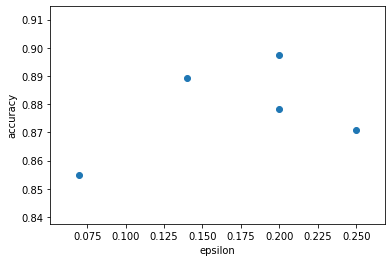

In [29]:
import matplotlib.pyplot as plt

plt.scatter(results[:, 0], results[:, 1])
plt.xlabel('epsilon')
plt.ylabel('accuracy')
plt.show()

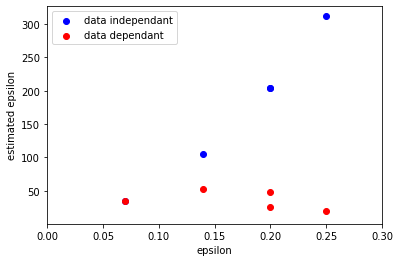

In [31]:
fig = plt.figure()
ax = fig.add_subplot()
#ax.set_ylim(0, 1)
ax.set_xlim(0, 0.3)
ax.scatter(results[:, 0], results[:, 3], c='b', label='data independant')
ax.scatter(results[:, 0], results[:, 2], c='r', label='data dependant')
plt.xlabel('epsilon')
plt.ylabel('estimated epsilon')
plt.legend(loc='upper left');
plt.show()

**Summary 1** 

We had trained 49 teachers, each of them predict accuracy very well: **0.77 .. 0.96**
Epsilon  **0.14** is the best choice so far. We minimize total epsilon but still keep decent accuracy. We could tune model, even more, using values **(0.07 .. 0.014)** 

In practice, it is not always possible to increase the amount of teacher(thought it might be useful) or force each of them to increase their dataset. 
Let's have a look at an example where our teachers have very limited datasets. 
We should add more noise at the very beginning to protect data even more. So we start with epsilon 0.25

Let's start training without noise at first to estimate baseline model accuracy.

In [32]:
train_subset_size = 100
test_subset_size = 100
run(teachers_names, student_name, train_subset_size, test_subset_size, use_noise=False, eps=0.25)

Teachers final accuracies range 0.5390625 .. 0.796875
Data Independent Epsilon: 	 36.51292546497023
Data Dependent Epsilon: 	 13.161250062031447
Student model accuracy 0.5946180820465088
Student model accuracy (big dataset) 0.6671974658966064


(tensor(0.6672), 13.161250062031447, 36.51292546497023)

In [ ]:
train_subset_size = 100
test_subset_size = 100
run(teachers_names, student_name, train_subset_size, test_subset_size, use_noise=True, eps=0.25)

Teachers final accuracies range 0.5494791269302368 .. 0.7638888955116272
Data Independent Epsilon: 	 36.51292546497023
Data Dependent Epsilon: 	 18.166271733813392
Student model accuracy 0.6788194179534912


**Summary2**  Noise do not degrade student model accuracy. Many teachers suffer from overfitting because of small datasets, so, noise gives a chance to second popular answer, that could be a better prediction.

It is worse to mention that sensitivity = 1 is a bit too much. When we remove one teacher, most probably we do not immediately remove one person and leak his/her data. If every teacher contains information about hundreds of people, sensitivity could be smaller. As a result, we could use a smaller epsilon. However, this requires some additional analytical work.

### Disclaimer

In this work was [PySyft](https://github.com/OpenMined/PySyft) was used to perform analysis. This library still in its early days. It is too early to use it to protect customer data. However, in a couple of months, this statement should be reviewed and hopefully removed.